# VOOF (Visualizing 1/f)

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from foof import syn
from foof.fit import FOOF
import numpy as np
import os
import scipy.io
import scipy.signal
import pandas as pd
from foof import syn
import seaborn as sns
import matplotlib.patches as patches

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Making some fake data with foof.syn

(96, 20)


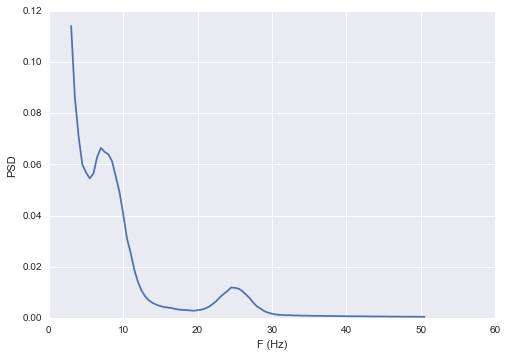

In [2]:
# Data settings
N = 20   # Number of PSDs
A = 0.1  # Peak height (0.005 give small but still clear; 0.2 gives huge peaks)
A2 = 0.02  # Peak height (0.005 give small but still clear; 0.2 gives huge peaks)
f = 8   # Frequency (3-100, Hz)
f2 = 25   # Frequency (3-100, Hz)
f_sig = 2  # Peak bandwidth (Hz)
f_sig2 = 2  # Peak bandwidth (Hz)
chi = 2  # Slope of the PSD (1-3)
noi = 0.05 # Noise to add to the PSD (0-0.4)
res = 0.5  # Spectral resolution (1-0.1, Hz)

fs, X = syn.synthesize(N, k=A, f=f, f_sig=f_sig, chi=chi,
                       f0=3, fmax=50, res=res, noi=noi)

fs,X2 = syn.synthesize(N, k=A2, f=f2, f_sig=f_sig2, chi=chi,
                       f0=3, fmax=50, res=res, noi=noi)

two_peak_spec= mean([X,X2],0)
print two_peak_spec.shape
# And plot
plt.plot(fs, np.mean(two_peak_spec,1))
plt.xlabel("F (Hz)")
plt.ylabel("PSD")

### Foof-ing the fake data

In [5]:
# Foof settings
max_components = 10  # Max number of Gaussians to consider

min_p = 0.3 # Min total probablity a peak must contain to be included
flatten_thresh = 0.05  # Useful for accounting large peaks and 'wiggly' PSDs, which often occur in real data (0-1) 

foof = FOOF(min_p=min_p,
            res=res,
            fmin=fs.min(),
            fmax=fs.max())

foof.model(fs, two_peak_spec)  # Fit PSD; Run time: 500-800 ms
print foof.centers_
print foof.stdevs_
print foof.powers_
print foof.chi_

[  9.13994677  25.42193866]
[ 1.41119008  1.98263325]
[ 0.05525586  0.01139006]
2.29683386323


//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Some helpful functions

In [6]:
def find_visual_wavelength_of_frequency_center(cf,freq_lo,freq_hi,vis_lo,vis_hi,res):
    """Finds the visual wavelength of a center frequency"""
    spec = np.linspace(freq_lo,freq_hi,(freq_hi+1-freq_lo)/res);
    closest_ind = min(range(len(spec)), key=lambda i: abs(spec[i]-cf))
    visual_x_frequency_spectrum = np.linspace(visual_spectrum[0],visual_spectrum[1],num = (frequency_spectrum[1]-frequency_spectrum[0])/res)
    flipped_ind = len(visual_x_frequency_spectrum) - closest_ind
    wavelength = visual_x_frequency_spectrum[flipped_ind]
    
    return wavelength


def chi_to_wavelength(chi,slope_range,visual_spectrum):
    """Takes a slope and returns the 'visual wavelength associated with it'"""
    
    chi_to_wl = np.linspace(0,4,num = (visual_spectrum[1]-visual_spectrum[0]))
    closest_wl_ind = min(range(len(chi_to_wl)), key=lambda i: abs(chi_to_wl[i]-chi))
    vis = np.linspace(visual_spectrum[0],visual_spectrum[1],num=visual_spectrum[1]-visual_spectrum[0]+1)
    
    return vis[closest_wl_ind]


def wav2RGB(wavelength):
    """very helpful code I stole from http://codingmess.blogspot.com/2009/05/conversion-of-wavelength-in-nanometers.html"""
    w = int(wavelength)

    # colour
    if w >= 380 and w < 440:
        R = -(w - 440.) / (440. - 350.)
        G = 0.0
        B = 1.0
    elif w >= 440 and w < 490:
        R = 0.0
        G = (w - 440.) / (490. - 440.)
        B = 1.0
    elif w >= 490 and w < 510:
        R = 0.0
        G = 1.0
        B = -(w - 510.) / (510. - 490.)
    elif w >= 510 and w < 580:
        R = (w - 510.) / (580. - 510.)
        G = 1.0
        B = 0.0
    elif w >= 580 and w < 645:
        R = 1.0
        G = -(w - 645.) / (645. - 580.)
        B = 0.0
    elif w >= 645 and w <= 780:
        R = 1.0
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0

    # intensity correction
    if w >= 380 and w < 420:
        SSS = 0.3 + 0.7*(w - 350) / (420 - 350)
    elif w >= 420 and w <= 700:
        SSS = 1.0
    elif w > 700 and w <= 780:
        SSS = 0.3 + 0.7*(780 - w) / (780 - 700)
    else:
        SSS = 0.0
    SSS *= 255

    return [int(SSS*R), int(SSS*G), int(SSS*B)]


def rgb_to_hex(rgb):
    """Helpful code stolen from http://stackoverflow.com/questions/214359/converting-hex-color-to-rgb-and-vice-versa"""
    return '#%02x%02x%02x' % rgb

### defining fx, visual, and slope ranges

In [7]:
visual_spectrum = [380, 750];
frequency_spectrum = [1,50];
slope_range = [0,4];

# Voofing

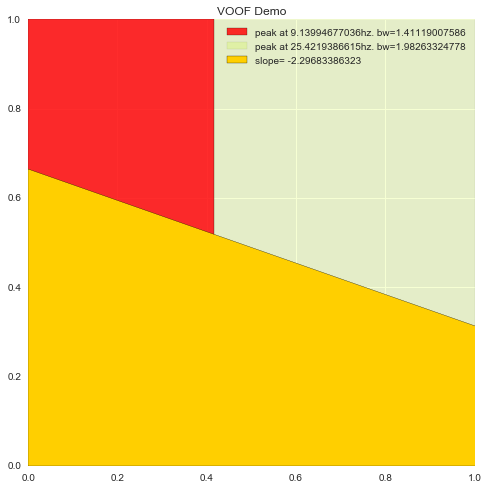

In [8]:
bandwidth_fracts = [i/sum(foof.stdevs_) for i in foof.stdevs_]
power_fracts = [i/sum(foof.powers_) for i in foof.powers_]
visual_wavelengths = [find_visual_wavelength_of_frequency_center(i,frequency_spectrum[0],frequency_spectrum[1],visual_spectrum[0],visual_spectrum[1],res) for i in foof.centers_]

fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111, aspect='equal')
i=0
for bw in xrange(len(foof.stdevs_)):
    ax1.add_patch(
        patches.Rectangle(
            (i, 0),   # (x,y)
            bandwidth_fracts[bw],          # width
            1,          # height
            facecolor= rgb_to_hex(tuple(wav2RGB(visual_wavelengths[bw]))),
            alpha = power_fracts[bw],
            label = 'peak at ' +str(foof.centers_[bw])+'hz. bw='+ str(foof.stdevs_[bw])
        )
    )
    i=i+bandwidth_fracts[bw]
    #print bw
ax1.set_xlim([0,1])
bump = 1/foof.chi_
polygon_params = [[0,(foof.chi_/10)+bump],[0,0],[0-bump/(-foof.chi_/10),0]]; #some y=mx+b stuff

ax1.add_patch(patches.Polygon(polygon_params, True,label='slope= -'+str(foof.chi_),
                             facecolor = rgb_to_hex(tuple(wav2RGB(chi_to_wavelength(foof.chi_,slope_range,visual_spectrum))))))
plt.title('VOOF Demo')
plt.legend()